# Esercitazione 4: classificazione cani e gatti

## Caricamento librerie

In [6]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from skimage import feature, color, transform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import ml_utilities
import ml_visualization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Caricamento dataset

Caricamento in corso ...
Caricate 900 immagini in 4.32 s.
Gatti: 509
Cani: 391


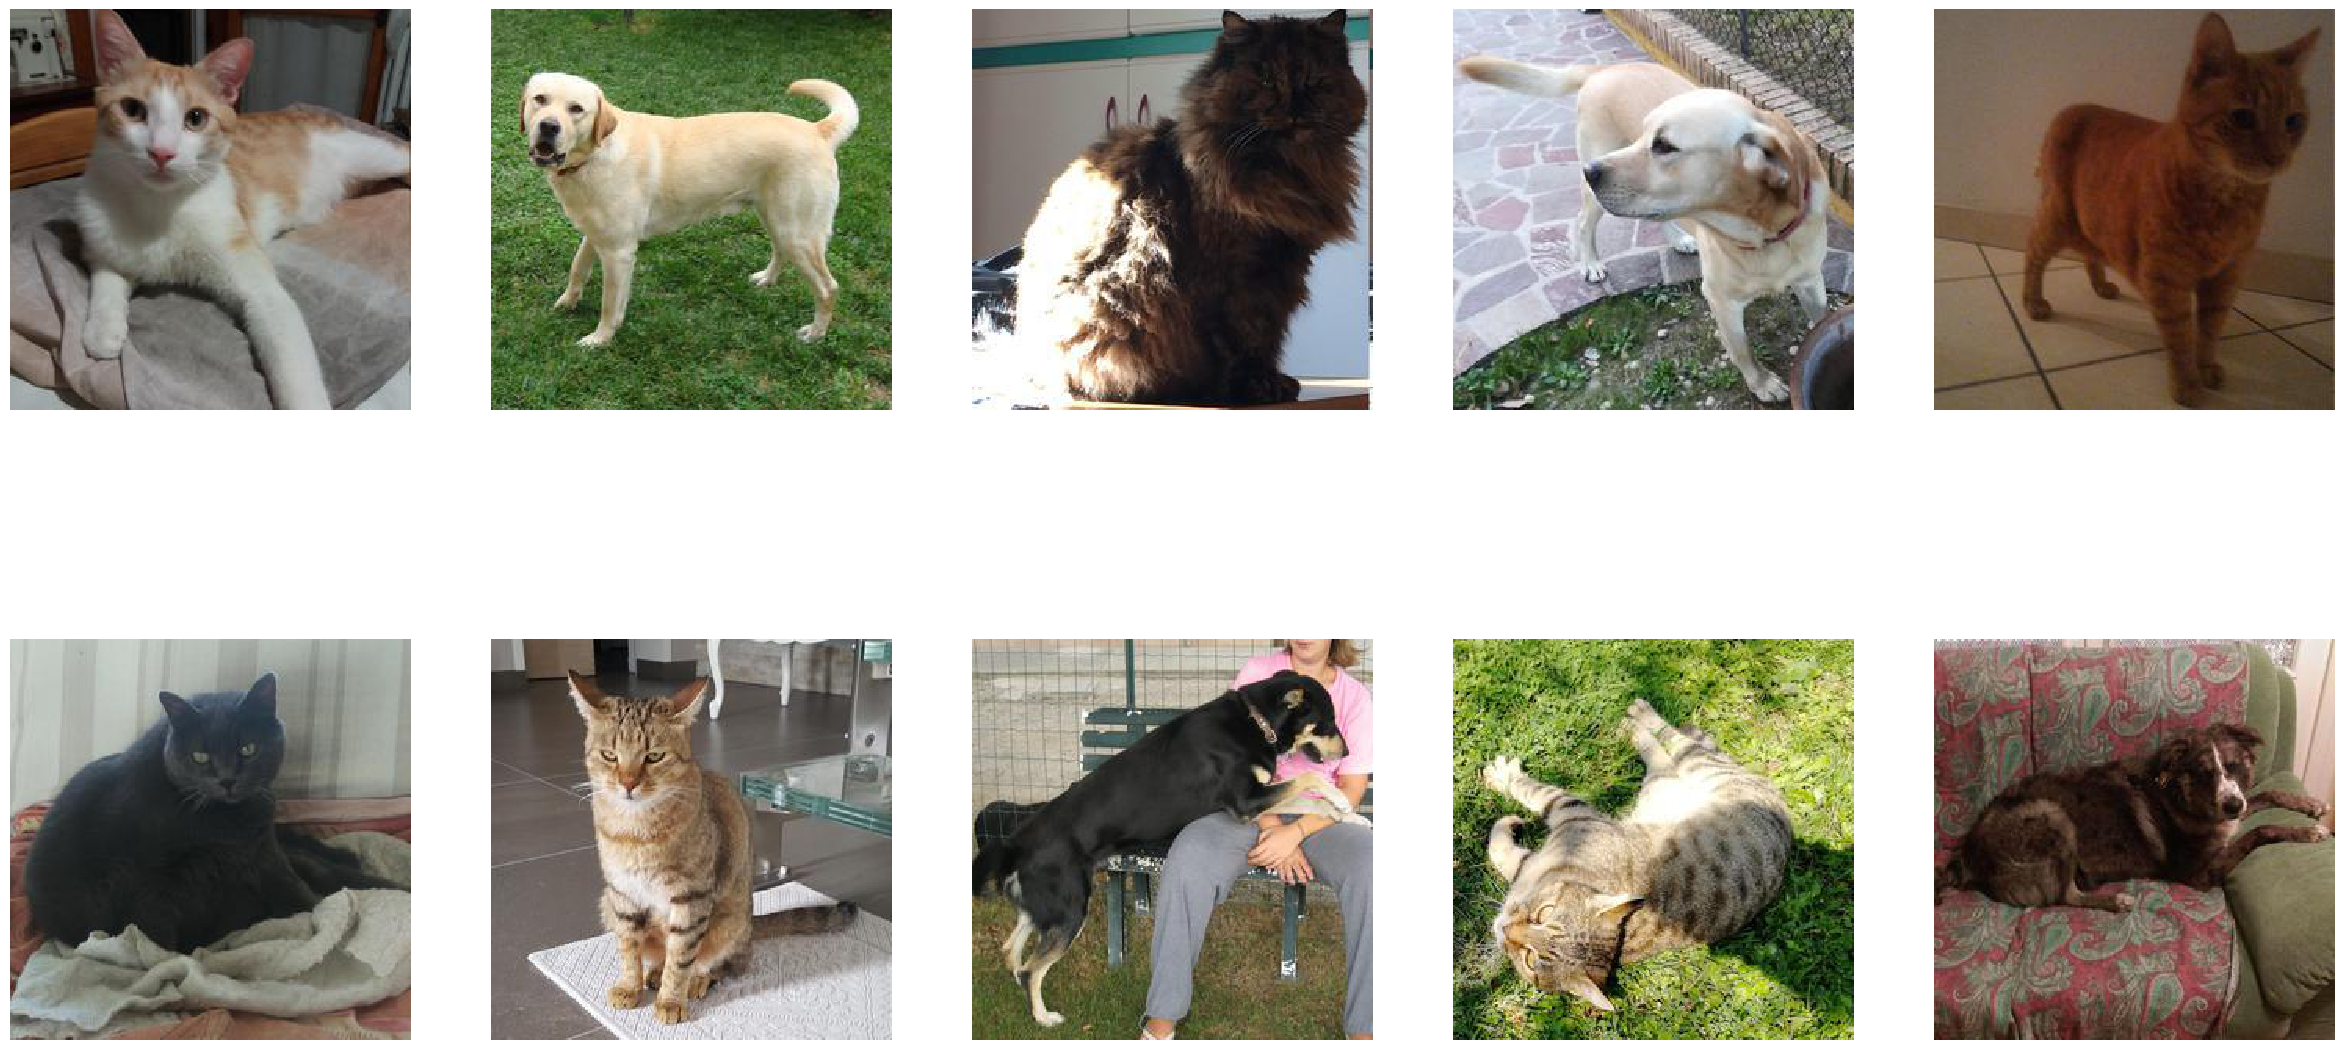

In [2]:
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt'  

# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

print('Caricate %d immagini in %.2f s.' % (len(train_raw_x), time.time() - start))
print('Gatti:', np.count_nonzero(train_y == 0))
print('Cani:', np.count_nonzero(train_y == 1))

# Shuffle del training set
ml_utilities.shuffle_in_unison([train_raw_x, train_y], seed=1234)

# Visualizzazione immagini
_, axs = plt.subplots(2, 5,figsize=(30, 15))
for i in range(5):
    axs[0,i].imshow(train_raw_x[i]),axs[0,i].axis('off')
    axs[1,i].imshow(train_raw_x[5+i]),axs[1,i].axis('off')
plt.show()

## Resizing immagini

In [4]:
image_side = 128
train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)

## Estrazione delle feature HOG

In [5]:
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=True, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)

## GridSearch sui classificatori

### kNN

In [7]:
#Modello k-NN

kNN_model = Pipeline([
    ("scaler", None),
    ("kNN", KNeighborsClassifier())
])

kNN_grid = {
    #'scaler': [None, StandardScaler()],
    'kNN__n_neighbors': range(1, 11), #iperparamtro k (numero di vicini da considerare)
    'kNN__weights': ['uniform', 'distance'], #uniform: tutti i punti vicini hanno lo stesso peso. distance: più i punti sono vicini più saranno influenti
}

kNN_gs = GridSearchCV(kNN_model, kNN_grid, cv=5, n_jobs=-1)
kNN_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', kNN_gs.best_params_)
print('Score:', kNN_gs.best_score_)

Parametri scelti: {'kNN__n_neighbors': 1, 'kNN__weights': 'uniform'}
Score: 0.6066666666666667


### SVM

In [8]:
#SVM

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

svm_grid = [
    #{
    #    'svm__kernel': ['linear'],
     #   'svm__C': np.linspace(1, 5, 10) #iperparametro di regolarizzazione
    #},
    {
        'svm__kernel': ['rbf'],
        'svm__C': np.linspace(1, 5, 20),
        'svm__gamma': np.logspace(-3, -5, 10) #coefficiente del kernel rbf
    }
]

svm_gs = GridSearchCV(svm_model, svm_grid, cv=4, n_jobs=-1)
svm_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', svm_gs.best_params_)
print('Score:', svm_gs.best_score_)

Parametri scelti: {'svm__C': 1.8421052631578947, 'svm__gamma': 0.00035938136638046257, 'svm__kernel': 'rbf'}
Score: 0.778888888888889


### Random Forest

In [29]:
#Random forest

rfc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier())
])

rfc_grid = {
    "rfc__max_depth": range(1, 13),
    "rfc__max_samples": [None, 0.1, 0.2, 0.5, 1],
    "rfc__max_features": ["sqrt", "log2"],
    "rfc__n_estimators": range(100, 1000, 100)
}

rfc_gs = GridSearchCV(rfc_model, rfc_grid, cv=4, n_jobs=-1)
rfc_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', rfc_gs.best_params_)
print('Score:', rfc_gs.best_score_)

Parametri scelti: {'rfc__max_depth': 12, 'rfc__max_features': 'sqrt', 'rfc__max_samples': None, 'rfc__n_estimators': 900}
Score: 0.75


### AdaBoost

In [28]:
#Adaboost

ada_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ada", AdaBoostClassifier())
])

ada_grid = {
    "ada__n_estimators": range(10, 100, 10),
    "ada__learning_rate": np.linspace(0.1, 3, 10)
}

ada_gs = GridSearchCV(ada_model, ada_grid, cv=4, n_jobs=-1)
ada_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', ada_gs.best_params_)
print('Score:', ada_gs.best_score_)

c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Parametri scelti: {'ada__learning_rate': 0.1, 'ada__n_estimators': 80}
Score: 0.7188888888888889


### XGBoost

In [11]:
#%pip install xgboost

In [12]:
from xgboost import XGBClassifier

In [13]:
#XGBoost

xgb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(objective='binary:logistic'))
])

xgb_grid = {
    "xgb__max_depth": [2, 4, 6, 8, 10],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__alpha": [0.001, 0.01, 0.1, 1]
}

xgb_gs = GridSearchCV(xgb_model, xgb_grid, cv=4, n_jobs=-1)
xgb_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', xgb_gs.best_params_)
print('Score:', xgb_gs.best_score_)

Parametri scelti: {'xgb__alpha': 0.01, 'xgb__max_depth': 2, 'xgb__n_estimators': 300}
Score: 0.75


### Regressione logistica

In [14]:
from sklearn.linear_model import LogisticRegression

In [27]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LogisticRegression())
])

log_grid = [
    {
        "linreg__penalty": ['l1', 'l2'],
        "linreg__solver": ['liblinear'],
        "linreg__C": np.linspace(0.1, 3, 5)
    },
    {
        "linreg__penalty": ['l1', 'l2'],
        "linreg__solver": ['saga'],
        "linreg__C": np.linspace(0.1, 3, 5)
    },
    {
        "linreg__penalty": ['elasticnet'],
        "linreg__solver": ['saga'],
        "linreg__C": np.linspace(0.1, 3, 5),
        "linreg__l1_ratio": np.linspace(0, 1, 10)
    }
]

log_gs = GridSearchCV(log_model, log_grid, cv=5, n_jobs=-1)
log_gs.fit(train_feature_x, train_y)

print('Parametri scelti:', log_gs.best_params_)
print('Score:', log_gs.best_score_)

Parametri scelti: {'linreg__C': 0.1, 'linreg__l1_ratio': 0.2222222222222222, 'linreg__penalty': 'elasticnet', 'linreg__solver': 'saga'}
Score: 0.7622222222222221


c:\Users\Lorenzo\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Test

In [ ]:
# Esercizio 2: valutazione su test set

# Path contenente i pattern di test
image_side = 128
db_path = 'DBs/CaniGatti_ML18'
exp_path = 'Experiments'
train_filelist = 'BinaryTrainingSet.txt' 
test_filelist = 'Unlabeled_BinaryTestSet.txt'
result_path = 'Es4Predictions.txt'
memory = Memory(exp_path, verbose=0) 

# Caricamento dei pattern di training
train_raw_x, train_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)
train_raw_x = ml_utilities.resize_images(train_raw_x, image_side, image_side, cache=memory)

# Preprocessing ed estrazione HOG (training)
train_feature_x = ml_utilities.extract_hog(train_raw_x, 
                                           convert_to_gray=True, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)

# Creazione del classificatore
clf = ... #TODO: trovare il migliore classificatore con i migliori iperparametri

# Addestramento del classificatore
clf.fit(train_feature_x, train_y)

# Caricamento dei pattern di test
test_raw_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)
test_raw_x = ml_utilities.resize_images(test_raw_x, image_side, image_side, cache=memory)

# Preprocessing ed estrazione HOG (test)
test_feature_x = ml_utilities.extract_hog(test_raw_x, 
                                           convert_to_gray=True, orientations=9,
                                           pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                           cache=memory)

# Salvataggio delle predictions
predictions = clf.predict(test_feature_x)

with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Ok')